# **나이브 베이즈 모델을 이용한 스팸메일 분류기**
Calssification

## **1 분류기 Classification**
1. **Binary Classification** (이진 분류기) : **True / False 조건을** 구분한다
1. **Multiclass Classification** (다변량 분류) : **다양한 클래스간의 조건을** 구분한다
1. **Multi-label Classification** (다중 클래스 레이블 분류) : 다중의 클래스간 **겹치는 조건에서** 구분을 한다

<img src="https://wikidocs.net/images/page/4291/logreg702.PNG" width=400>

## **2 텍스트 분류기 Classification**
1. **긍정/ 부정,  긍정/ 중립/ 부정** 분류기
1. **뉴스의 토픽** 분류기 (**class 간 중첩되어** 분류가 가능하다)
1. **Named Entity Recognition** (개체명 분류기) : ex) Naive Bayse, Support Vector Machine

## **3  Naive Bayse Classification 개념**
1. 확률 기반의 분류기
1. **Naive :** 예측을 위한 Token 들이 **Mutually Independent** (상호독립적)을 가정
1. **Bayse :** 관찰한 Token이 **클래스 전체 대비, 특정 클래스 속할 확률을 Bayse 기반** 으로 계산

> **Naive Bayse 메커니즘**

1. 스팸메일과, 정상메일로 구분된 데이터를 사용한다 [download](http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron1.tar.gz)
1. 단어 **Token을** 대상으로 **스팸여부를** 학습한다.
1. Data 추가시 잘못 예측한 결과에 대해 **Laplace Smoothing** 으로 보완한 값을 **Bayse 로 공식을** 수정한다

## **4   Naive Bayse 구현하기**
스펨메일 데이터 다운받기 [download](http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron1.tar.gz)
<br>
### **01 enron 메일데이터 살펴보기**
1. **Summary.txt** 파일에 저장된 내용 살펴보기
1. **정상메일 (3,672개)** 와 **스펨메일 (1,500)개로** 약 1:2의 비율로 구분이 된다

In [1]:
# 스팸메일 데이터 Summary
with open('./data/enron1/Summary.txt', 'r') as f:
    summary = f.read()
print(summary)

Legitimate
----------
- Owner: farmer-d
- Total number: 3672 emails
- Date of first email: 1999-12-10
- Date of last email: 2002-01-11
- Similars deletion: No
- Encoding: No


Spam
----
- Owner: GP
- Total number: 1500 emails
- Date of first email: 2003-12-18
- Date of last email: 2005-09-06
- Similars deletion: No
- Encoding: No

Spam:Legitimate rate = 1:3
Total number of emails (legitimate + spam): 5975



In [2]:
# ham 폴더에 저장된 메일내용 확인 (정상으로 분류된 메일)
file_path = './data/enron1/ham/0007.1999-12-14.farmer.ham.txt'
with open(file_path, 'r') as infile:
    ham_sample = infile.read()
print(ham_sample)

Subject: mcmullen gas for 11 / 99
jackie ,
since the inlet to 3 river plant is shut in on 10 / 19 / 99 ( the last day of
flow ) :
at what meter is the mcmullen gas being diverted to ?
at what meter is hpl buying the residue gas ? ( this is the gas from teco ,
vastar , vintage , tejones , and swift )
i still see active deals at meter 3405 in path manager for teco , vastar ,
vintage , tejones , and swift
i also see gas scheduled in pops at meter 3404 and 3405 .
please advice . we need to resolve this as soon as possible so settlement
can send out payments .
thanks


In [3]:
# spam 폴더에 저장된 메일내용 확인 (스팸으로 분류된 메일)
file_path = './data/enron1/spam/0058.2003-12-21.GP.spam.txt'
with open(file_path, 'r') as infile:
    spam_sample = infile.read()
print(spam_sample)

Subject: stacey automated system generating 8 k per week parallelogram
people are
getting rich using this system ! now it ' s your
turn !
we ' ve
cracked the code and will show you . . . .
this is the
only system that does everything for you , so you can make
money
. . . . . . . .
because your
success is . . . completely automated !
let me show
you how !
click
here
to opt out click here % random _ text



### **02 enron 메일 데이터 분류하기**
1. 스펨메일과 정상메일을 레이블을 사용하여 분류한다
1. 1 : 스펨메일,  0 : 정상메일
1. 분류된 데이터를 전처리 과정을 진행한다

In [4]:
import glob,os
# 정상매일은 0, 스펨매일은 1
emails, labels = [], []
for no, file_path in enumerate(['./data/enron1/ham/','./data/enron1/spam/']):
    for filename in glob.glob(os.path.join(file_path, '*.txt')):
        with open(filename, 'r', encoding = "ISO-8859-1") as infile:
            emails.append(infile.read())
            labels.append(no)

### **03 enron 메일 데이터 임베딩**
1. Chapter 2 에서 진행한 내용을 바탕으로 전처리 작업을 진행한다
1. **숫자와 구두점** 제거, **StopWords** 제거, **표제어 원형** 복원
1. 정제된 데이터로 **희소벡터 (Sparse Vector)** 로 임베딩 ex) (**row index, feacture/term index**)

In [5]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer
all_names  = set(names.words())
lemmatizer = WordNetLemmatizer()

# 알파벳이 아닌 객체가 포함시 False를 출력
def letters_only(astr): 
    return astr.isalpha()

# 표제어 복원작업
def clean_text(docs):
    cleaned    = [' '.join([lemmatizer.lemmatize(word.lower())
                        for word in doc.split()
                        if letters_only(word) and word not in all_names])   
              for doc in docs]
    return cleaned

# 사용자 함수를 활용하여 전처리 작업을 진행한다
cleaned_emails = clean_text(emails)
cleaned_emails[0]

'fw customer list this one includes more financial counterparties non eol original message from winfree o neal d sent wednesday december am to martin thomas a subject customer list tom attached are eol customer between july and nov broken out by physical and financial the only physical customer i remember non eol are imperial sugar and texas energy i m also checking this list against other non eol deal eric or joe might have done but for now take a look at this o'

In [6]:
%%time
# 출현빈도가 높은 상위 500개의 Token을 대상으로 임베딩 한다
# 희소벡터(Sparse Vector)로 변환 : (row index, feacture/term index)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english", max_features=500)
term_docs      = cv.fit_transform(cleaned_emails)
print("모델의 Type: {}\n임베딩의 크기: {}\n0번문장 내용보기: \n{}".format(
    type(term_docs),
    term_docs.shape, # 5,172개 문장을 500개 단어로 생성
    term_docs [0]))  # 0번 문장의 단어 Vector 목록을 출력

모델의 Type: <class 'scipy.sparse.csr.csr_matrix'>
임베딩의 크기: (5172, 500)
0번문장 내용보기: 
  (0, 248)	1
  (0, 102)	1
  (0, 125)	1
  (0, 435)	1
  (0, 224)	1
  (0, 30)	1
  (0, 447)	1
  (0, 417)	1
  (0, 104)	1
  (0, 482)	1
  (0, 390)	1
  (0, 265)	1
  (0, 307)	1
  (0, 147)	2
  (0, 241)	3
  (0, 94)	4
  (0, 162)	1
CPU times: user 594 ms, sys: 4.05 ms, total: 598 ms
Wall time: 597 ms


In [7]:
# cv 모델로 인덱스별 단어 Token 내용보기
# feature_mapping = cv.vocabulary_       # dict 로 내용출력 (key:value)

print(cv.get_feature_names()[:7])
feature_names   = cv.get_feature_names() # List 로 내용출력 (인덱스별 value)
for indx in [0, 162, 481, 357, 125]:
    print(indx, ":", feature_names[indx])

['able', 'access', 'account', 'accounting', 'act', 'action', 'activity']
0 : able
162 : fw
481 : website
357 : read
125 : energy


### **04-1 Naive Bayse 학습을 위한 준비작업**
모델의 학습을 위한 준비작업으로 데이터를 그룹화 한다

In [8]:
# 레이블을 기준으로 데이터를 그룹화 한다
# defaultdict : 스팸여부 0,1 Tag 로 Token Index List 생성
def get_label_index(labels):
    from collections import defaultdict
    label_index = defaultdict(list)
    for index, label in enumerate(labels):
        label_index[label].append(index)
    return label_index

# 0 ~ 3600 : 정상메일, 3600 ~ 나머지 : 스팸메일
label_index = get_label_index(labels)

### **04-2 Naive Bayse 위한 사전확률/ 우도값 계산**
**사전확률 및 우도값을** 계산하는 함수를 정의한다

In [9]:
# 학습 샘플을 활용하여 사전 확률을 계산하는 
def get_prior(label_index):
    """ Compute prior based on training samples
    Args:    label_index (grouped sample indices by class)
    Returns: dictionary, with class label as key, corresponding prior as the value """
    prior = {label: len(index) for label, index in label_index.items()}
    total_count = sum(prior.values())
    for label in prior:
        prior[label] /= float(total_count)
    return prior

# 위의 인덱스 데이터를 활용하여 사전확률을 계산한다
prior = get_prior(label_index)
prior

{0: 0.7099767981438515, 1: 0.2900232018561485}

In [10]:
import numpy as np
# 확률적 우도값을 계산하는 함수
# 위에서 추출한 빈도상위 500개의 단어로 조건부 확률 p(feature|spam) 을 계산
def get_likelihood(term_document_matrix, label_index, smoothing=0):
    """ Compute likelihood based on training samples
    Args:
        term_document_matrix (sparse matrix)
        label_index (grouped sample indices by class)
        smoothing (integer, additive Laplace smoothing parameter)
    Returns: 
        dictionary, with class as key, corresponding conditional probability P(feature|class) vector as value
    """
    likelihood = {}
    for label, index in label_index.items():
        likelihood[label] = term_document_matrix[index, :].sum(axis=0) + smoothing
        likelihood[label] = np.asarray(likelihood[label])[0]
        total_count       = likelihood[label].sum()
        likelihood[label] = likelihood[label] / float(total_count)
    return likelihood

# 라플라스 스무딩시 추가할 값 1
smoothing  = 1
likelihood = get_likelihood(term_docs, label_index, smoothing)
# 0 번(정상메일) 자료 중 1~20번 메일의 우도 값
likelihood[0][:20]

array([1.08580656e-03, 9.57737068e-04, 8.79781725e-04, 8.46372292e-04,
       1.00228298e-04, 2.39434267e-04, 1.97115652e-03, 1.34194554e-03,
       1.84308703e-03, 8.35235815e-04, 1.08023832e-03, 1.03012417e-03,
       1.67047163e-05, 1.50342447e-04, 7.62848711e-04, 8.40804054e-04,
       8.12962860e-04, 2.22172727e-03, 1.99342948e-03, 5.01141489e-05])

In [11]:
# 인덱스에 연계된 단어들을 확인
feature_names[:5]

['able', 'access', 'account', 'accounting', 'act']

### **04-3 자연 Log 를 활용한 예측함수 구현하기**
**사전확률 및 우도값을** 계산하는 함수를 정의한다

In [12]:
# OverFlow가 발생 가능하므로, 데이터를 Log() 자연로그로 변환 후 덧셈 계산,
# 계산이 끝난 뒤, 로그의 역함수 (exp()) 를 활용하여 실수로 변환한다
def get_posterior(term_document_matrix, prior, likelihood):
    """ Compute posterior of testing samples, based on prior and likelihood
    Args:
        term_document_matrix (sparse matrix)
        prior (dictionary, with class label as key, corresponding prior as the value)
        likelihood (dictionary, with class label as key, corresponding conditional probability vector as value)
    Returns:
        dictionary, with class label as key, corresponding posterior as value
    """
    num_docs   = term_document_matrix.shape[0]
    posteriors = []
    for i in range(num_docs):
        # posterior is proportional to prior * likelihood
        # = exp(log(prior * likelihood))
        # = exp(log(prior) + log(likelihood))
        posterior = {key: np.log(prior_label) for key, prior_label in prior.items()}
        for label, likelihood_label in likelihood.items():
            term_document_vector = term_document_matrix.getrow(i)
            counts = term_document_vector.data
            indices = term_document_vector.indices
            for count, index in zip(counts, indices):
                posterior[label] += np.log(likelihood_label[index]) * count
        # exp(-1000):exp(-999) will cause zero division error,
        # however it equates to exp(0):exp(1)
        min_log_posterior = min(posterior.values())
        for label in posterior:
            try:
                posterior[label] = np.exp(posterior[label] - min_log_posterior)
            except:
                # if one's log value is excessively large, assign it infinity
                posterior[label] = float('inf')
        # normalize so that all sums up to 1
        sum_posterior = sum(posterior.values())
        for label in posterior:
            if posterior[label] == float('inf'):
                posterior[label] = 1.0
            else:
                posterior[label] /= sum_posterior
        posteriors.append(posterior.copy())
    return posteriors

In [13]:
# 테스트 메일을 사용하여 알고리즘을 검증해본다
emails_test = [
    '''Subject: flat screens hello ,
    please call or contact regarding the other flat screens requested .
    trisha tlapek - eb 3132 b michael sergeev - eb 3132 a
    also the sun blocker that was taken away from eb 3131 a .
    trisha should two monitors also michael .thanks kevin moore''',
    
    '''Subject: having problems in bed ? we can help !
    cialis allows men to enjoy a fully normal sex life without having to plan the sexual act .
    if we let things terrify us , life will not be worth living .
    brevity is the soul of lingerie . suspicion always haunts the guilty mind .''']

# 검증결과 0번 메일은 0.99로 정상, 1번 메일은 0.99로 스펨메일
# 그런데 1번메일의 결과값 총 합아 1을 넘어가냐 ???
cleaned_test   = clean_text(emails_test)
term_docs_test = cv.transform(cleaned_test)
posterior      = get_posterior(term_docs_test, prior, likelihood)
from pprint import pprint
pprint(posterior)

[{0: 0.9815828838777807, 1: 0.018417116122219333},
 {0: 1.5274461154428757e-06, 1: 0.9999984725538845}]


### **04-4 학습을 위해 Train / Test 데이터를 나눈다**
scikit-learn 모듈 **train_test_split** 을 사용한다

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    cleaned_emails, 
    labels, 
    test_size    = 0.33, 
    random_state = 42)
print("Train Data Length X : {:,}, Y : {:,}\nTest Data Length  X : {:,}, Y : {:,}".format(
    len(X_train), len(Y_train), len(X_test), len(Y_test)))

Train Data Length X : 3,465, Y : 3,465
Test Data Length  X : 1,707, Y : 1,707


In [15]:
# 데이터 Set의 사후 확률을 예측한다
term_docs_train = cv.fit_transform(X_train)
label_index     = get_label_index(Y_train)
prior           = get_prior(label_index)
likelihood      = get_likelihood(term_docs_train, label_index, smoothing)

# Test / 신규 데이터 Set의 사후확률을 예측한다
term_docs_test = cv.transform(X_test)
posterior = get_posterior(term_docs_test, prior, likelihood)
correct   = 0.0

for pred, actual in zip(posterior, Y_test):
    if actual == 1:
        if pred[1] >= 0.5:
            correct += 1
    elif pred[0] > 0.5:
        correct += 1

# dtype 을 128 이상으로 지정할 것
# https://stackoverflow.com/questions/40726490/overflow-error-in-pythons-numpy-exp-function/40726641
print('{:,} 개의 테스트 데이터(Y_test)의 정확도는: {:.1f} %'.format(
    len(Y_test), correct/len(Y_test)*100))

/home/markbaum/Python/python/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


1,707 개의 테스트 데이터(Y_test)의 정확도는: 91.6 %


<br/>
## **5 Sklearn 을 활용한 Naive Bayse 구현하기**
위에서 복잡한 과정을 통해서 내용을 숙달하길 바라며, sklearn으로 위의 내용을 진행해본다
### **01 데이터 전처리 및 모델학습**
모델을 학습한 뒤 정확도를 측정한다

In [16]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha     = 1.0,  # Laplace Smoothing 값
                    fit_prior = True) # Data Set로 학습된 사전확률 사용
clf.fit(term_docs_train, Y_train)

# 예측 결과값을 계산한다
prediction_prob = clf.predict_proba(term_docs_test)
prediction_prob[0:6]

array([[9.99808489e-01, 1.91511166e-04],
       [9.99999772e-01, 2.28176513e-07],
       [9.99999223e-01, 7.77402015e-07],
       [9.99999724e-01, 2.76311984e-07],
       [9.98447799e-01, 1.55220148e-03],
       [1.00000000e+00, 2.17331050e-15]])

In [17]:
# 예측한 클래스 값을 바로 계산하여 출력한다
# 역치값은 0.5로 0.5보다 크면 1, 작으면 0을 출력
prediction = clf.predict(term_docs_test)
prediction[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [18]:
# test 값을 활용하여 모델의 정확도 측정 
accuracy = clf.score(term_docs_test, Y_test)
print('The accuracy using MultinomialNB is: {0:.1f}%'.format(accuracy*100))

The accuracy using MultinomialNB is: 91.6%


<br>
### **02 분류기의 성능 평가**
**혼동행렬(Confusion Matrix) 분할표로** 예측값을 테스트하여 출력한다

<img src="https://docs.microsoft.com/ko-kr/azure/machine-learning/studio/media/evaluate-model-performance/6a.png" align="left">

In [19]:
# 혼동행렬 값을계산해보자
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, prediction, labels=[0, 1])

array([[1138,   91],
       [  52,  426]])

In [20]:
# f1 Score 를 측정하여 정밀도, 재연율을 계산
from sklearn.metrics import precision_score, recall_score, f1_score
print("""Precesion(정밀도) : {:.4}\nRecall(재현율) : {:.4}
f1 score (1) : {:.4} \nf1 score (0) : {:.4}""".format(
    precision_score(Y_test, prediction, pos_label=1),
    recall_score(Y_test, prediction, pos_label=1),
    f1_score(Y_test, prediction, pos_label=1),
    f1_score(Y_test, prediction, pos_label=0)))

Precesion(정밀도) : 0.824
Recall(재현율) : 0.8912
f1 score (1) : 0.8563 
f1 score (0) : 0.9409


In [21]:
# 위와 같은내용을 한꺼번에 실행해본다
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1229
           1       0.82      0.89      0.86       478

   micro avg       0.92      0.92      0.92      1707
   macro avg       0.89      0.91      0.90      1707
weighted avg       0.92      0.92      0.92      1707



### **03 분류기의 성능 평가**
1. **정확도**(훈련데이터 적합도) 와 **재현율**(일반화 정도)이 **모두 높은 경우가 없기** 때문에 f1-score를 측정한다
1. 하지만 모델의 **평균값과,** 모델의 **f1-score** 둘 다 높은 모델은 없으므로 별도 기준이 필요
1. 대표적인 대안으로 **ROC (Receiver Operation Characteristic), AUC (Area Under the Curve)** 가 있다
1. 이번 예제에서는 **ROC**를 그려보자

In [22]:
%%time
# ROC Curve를 그려보자
pos_prob   = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.2, 0.1)
true_pos   = [0]*len(thresholds) 
false_pos  = [0]*len(thresholds)

for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1: true_pos[i] += 1
            else:      false_pos[i] += 1
        else: break

# 임계치를 설정하기 위해 양성비율과, 음성 비율을 계산한다
# 양성 테스트 샘플이 516개, 음성 테스트 샘플이 1,191개 이다
true_pos_rate  = [tp / 516.0 for tp in true_pos]
false_pos_rate = [fp / 1191.0 for fp in false_pos]

CPU times: user 2.65 ms, sys: 0 ns, total: 2.65 ms
Wall time: 2.61 ms


No handles with labels found to put in legend.


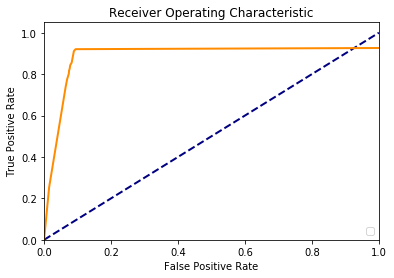

In [23]:
%matplotlib inline
# ROC Curve 를 출력한다
import matplotlib.pyplot as plt

# BaseLine을 그린다
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(false_pos_rate, true_pos_rate, color = 'darkorange', lw = lw)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right"); plt.show()

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob)

0.9629610085418291

<br>
## **6 Sklearn 을 활용한 모델의 튜닟 및 교차검증**
1. 모델이 실질적으로 잘 작동하는지 **K-fold 검정을** 적용한다
1. **AUC 값의** 측정 : **ROC 커브의** 밑면적을 구한 값으로 **1에 가까울수록** 성능이 좋다.[참고](http://newsight.tistory.com/53)

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg" align="left">

In [25]:
# 전체 10개의 폴드 생성기로 초기화 후 파라미터 분석을 진행합니다
from sklearn.model_selection import StratifiedKFold
k = 10
k_fold = StratifiedKFold(n_splits=k)

# 연산을 위해 Numpy 객체로 변환한다
cleaned_emails_np = np.array(cleaned_emails)
labels_np         = np.array(labels)

# 10 폴드 생성기 학습을 위한 파라미터를 정의합니다
max_features_option     = [2000, 4000, 8000]   # 가장 많이 사용되는 N개 단어를 선택
smoothing_factor_option = [0.5, 1.0, 1.5, 2.0] # Smoothing Parameter : 초기값
fit_prior_option        = [True, False]        # 사전 확률을 사용할지 여부

In [26]:
%%time
auc_record = {}
for train_indices, test_indices in k_fold.split(cleaned_emails, labels):
    X_train, X_test = cleaned_emails_np[train_indices], cleaned_emails_np[test_indices]
    Y_train, Y_test = labels_np[train_indices], labels_np[test_indices]
    for max_features in max_features_option:
        if max_features not in auc_record:
            auc_record[max_features] = {}
        cv = CountVectorizer(stop_words="english", max_features=max_features)
        term_docs_train = cv.fit_transform(X_train)
        term_docs_test  = cv.transform(X_test)
        for smoothing_factor in smoothing_factor_option:
            if smoothing_factor not in auc_record[max_features]:
                auc_record[max_features][smoothing_factor] = {}
            for fit_prior in fit_prior_option:
                clf = MultinomialNB(alpha=smoothing_factor, fit_prior=fit_prior)
                clf.fit(term_docs_train, Y_train)
                prediction_prob = clf.predict_proba(term_docs_test)
                pos_prob = prediction_prob[:, 1]
                auc = roc_auc_score(Y_test, pos_prob)
                auc_record[max_features][smoothing_factor][fit_prior] \
                    = auc + auc_record[max_features][smoothing_factor].get(fit_prior, 0.0)

print(auc_record)

{2000: {0.5: {True: 9.774037510366071, False: 9.77421866978636}, 1.0: {True: 9.759365473087707, False: 9.760037293172216}, 1.5: {True: 9.748388421593019, False: 9.747397943569085}, 2.0: {True: 9.737427906448682, False: 9.735719972949493}}, 4000: {0.5: {True: 9.84587346483434, False: 9.845428291474153}, 1.0: {True: 9.833152396043122, False: 9.83388784405481}, 1.5: {True: 9.823646536745251, False: 9.824236662322791}, 2.0: {True: 9.81472984046124, False: 9.813894113059273}}, 8000: {0.5: {True: 9.885893851439404, False: 9.885203569877188}, 1.0: {True: 9.875745024286223, False: 9.87436441179955}, 1.5: {True: 9.870388826363387, False: 9.87023407574142}, 2.0: {True: 9.865715209493345, False: 9.865261027524385}}}
CPU times: user 25.1 s, sys: 1.24 s, total: 26.3 s
Wall time: 26.3 s


In [27]:
# 위에서 계산한 결과를 출력하빈다
print('max features  smoothing  fit prior  auc')
for max_features, max_feature_record in auc_record.items():
    for smoothing, smoothing_record in max_feature_record.items():
        for fit_prior, auc in smoothing_record.items():
            print('       {0}      {1}      {2}    {3:.4f}'.format(max_features, smoothing, fit_prior, auc/k))

max features  smoothing  fit prior  auc
       2000      0.5      True    0.9774
       2000      0.5      False    0.9774
       2000      1.0      True    0.9759
       2000      1.0      False    0.9760
       2000      1.5      True    0.9748
       2000      1.5      False    0.9747
       2000      2.0      True    0.9737
       2000      2.0      False    0.9736
       4000      0.5      True    0.9846
       4000      0.5      False    0.9845
       4000      1.0      True    0.9833
       4000      1.0      False    0.9834
       4000      1.5      True    0.9824
       4000      1.5      False    0.9824
       4000      2.0      True    0.9815
       4000      2.0      False    0.9814
       8000      0.5      True    0.9886
       8000      0.5      False    0.9885
       8000      1.0      True    0.9876
       8000      1.0      False    0.9874
       8000      1.5      True    0.9870
       8000      1.5      False    0.9870
       8000      2.0      True    0.9866
      